<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>

# Deep Neural Networks for Recommender Systems

In the previous [notebook](2-02_dataloader.ipynb), we built a deep neural network based on two categorical features userID and productID. In the same way, we can use multiple categorical features as input to our neural network. 

## Objectives 
* How to add additional context to our recommender system
  * [1. Using NVTabular dataloader](#1.-Using-NVTabular-dataloader)
  * [2. Deep Neural Network Using Multiple Categorical Columns](#2.-Deep-Neural-Network-Using-Multiple-Categorical-Columns)
* How to add numerical features to recommender DNNs
  * [3. Adding Numerical Features](#3.-Adding-Numerical-Features)
* How to multi-hot encode with Keras
  * [4. Building a Multi-Hot Model](#4.-Building-a-Multi-Hot-Model)
  * [5. Wrap Up](#5.-Wrap-Up)

## 1. Using NVTabular dataloader
Before we start expanding our model, we are going to be using our same dataset for the next few models. It would be convenient if we didn't have to copy and paste the code each time.

Please fill in the `FIXME`'s below and run the cell to write the code out to `dataset.py`. The [previous notebook](2-02_dataloader.ipynb) can be used as a hint.

In [5]:
%%writefile dataset.py
import os
os.environ["TF_MEMORY_ALLOCATION"] = "0.7"

from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
import nvtabular as nvt
import cudf

data_dir = "data/task_2.csv"


def get_ds_from_df(df_tmp, cat_cols, cont_cols, label=["overall"], batch_size=1024):
    # FIXME: add inputs to KerasSequenceLoader
    dataset = KerasSequenceLoader(
        nvt.Dataset(df_tmp),
        batch_size=batch_size,
        label_names=label,
        cat_names=cat_cols,
        cont_names=cont_cols,
        shuffle=True,
        buffer_size=0.06
    )
    return dataset


def get_test_and_train(cat_cols=[], cont_cols=[], df=None):
    # FIXME: use inputs to select training and validation datasets
    ratings = cudf.read_csv(data_dir) if df is None else df
    train_ds = ratings[~ratings["valid"]]
    train_ds = get_ds_from_df(train_ds, cat_cols, cont_cols)

    valid_ds = ratings[ratings["valid"]]
    valid_ds = get_ds_from_df(valid_ds, cat_cols, cont_cols)

    return train_ds, valid_ds

Overwriting dataset.py


Let's test it right away by loading our `train_ds` ans `valid_ds`. First, let's use the [%load_ext autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) cell magic so if we need to make changes to `dataset.py`, we can reload the new file.

In [7]:
%reload_ext autoreload

Now, we can load our data.

In [8]:
%autoreload 2
import dataset

categorical_columns = ["user_index", "item_index", "brand_index"]
train_ds, valid_ds = dataset.get_test_and_train(categorical_columns)

In [9]:
ds_itr = iter(train_ds)
sample = next(ds_itr)
sample

({'brand_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[3097],
         [   0],
         [1977],
         ...,
         [2345],
         [   0],
         [   0]])>,
  'item_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[58080],
         [21561],
         [12617],
         ...,
         [17417],
         [57627],
         [23593]])>,
  'user_index': <tf.Tensor: shape=(1024, 1), dtype=int64, numpy=
  array([[ 64298],
         [103393],
         [164947],
         ...,
         [ 95974],
         [139643],
         [134286]])>},
 <tf.Tensor: shape=(1024, 1), dtype=float64, numpy=
 array([[4.],
        [4.],
        [3.],
        ...,
        [4.],
        [5.],
        [5.]])>)

Before moving on, please make sure the dataset passes the following tests:

In [10]:
assert len(sample) == 2
assert sample[0]["user_index"].shape == (1024,1)
assert sample[0]["item_index"].shape == (1024,1)
assert sample[1].shape == (1024,1)
print("Pass!")

Pass!


## 2. Deep Neural Network Using Multiple Categorical Columns
Let's create some functions to support an arbitrary number of categorical inputs. First, we'll load the libraries we need for this notebook.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cudf
import cupy as cp
from cupyx.scipy.special import erfinv
import tensorflow as tf
from scipy.special import erfinv as sp_erfinv
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense

We can next use [Python dictionary comprehension](https://www.python.org/dev/peps/pep-0274/) to define a dictionary of input tensors.

In [12]:
input_tensor = {
    col: Input(name=col, shape=(1,), dtype="int64") for col in categorical_columns
}
input_tensor

{'user_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'user_index')>,
 'item_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'item_index')>,
 'brand_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'brand_index')>}

Since all of our future models will include our embeddings and dense layers that we had before, it would also be handy to have a function to define this part of our architecture for us so we don't have to do it every time. In the [last notebook](2-02_dataloader.ipynb) we had:

1. [Inputs](https://www.tensorflow.org/api_docs/python/tf/keras/Input)
1. [Embeddings](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)
2. [Concatenation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/concatenate)
3. [Dense Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
4. Outputs

While we're making this new function, we'd like to include as many categorical embeddings as we like as well as a way to include other new features, which we'll do through our `concatenate` layer. Please fill in the `FIXME`s below, using the [previous notebook](2-02_dataloader.ipynb) as a guide. `input_tensor` above will be used for `embedding_inputs` below.

In [17]:
%%writefile deep.py
import cudf
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense

ratings = cudf.read_csv("data/task_2.csv")


def get_model(
    embedding_inputs={},
    concatenate_layers=[],  # Ignore for now
    emb_size=32,
    hidden_layers=[256, 128],
):

    # Make embeddings
    embeddings = []
    for col in embedding_inputs:
        # FIXME: build a list of embedding layers
        max_index = int(ratings[col].max() + 1)
        embedding_input = embedding_inputs[col]
        embedding_layer = Embedding(max_index, emb_size, name="emb_" + col)
        embeddings.append(tf.squeeze(embedding_layer(embedding_input), axis=1))

    # The current layer at the end of our function chain
    end_layer = concatenate(concatenate_layers + embeddings, axis=1)
    for i, units in enumerate(hidden_layers):
        end_layer = Dense(units, activation="relu", name="dnn_{}".format(i))(end_layer)
    return Dense(1, activation=None, name="pred")(end_layer)

Overwriting deep.py


Let's verify that our function works by compiling a model.

In [18]:
%autoreload 2
import deep
output_tensor = deep.get_model(embedding_inputs = input_tensor)
model = tf.keras.Model(input_tensor, output_tensor)

We can also verify our model by visualizing the architecture. If we add `show_shapes=True`, we can see the dimensions of our hidden layers. Please check for the following:

* Are there three Embedding layers, one for each Input layer?
* Are the output shapes of the Embedding layers `(?, 1, 32)`?
* Is the output of the Concatenate layer `(?, 96)`?
* Are there three Dense layers? `dnn_0`, `dnn_1` and `pred`?
* Does `pred` have an output shape of `(?,1)`?

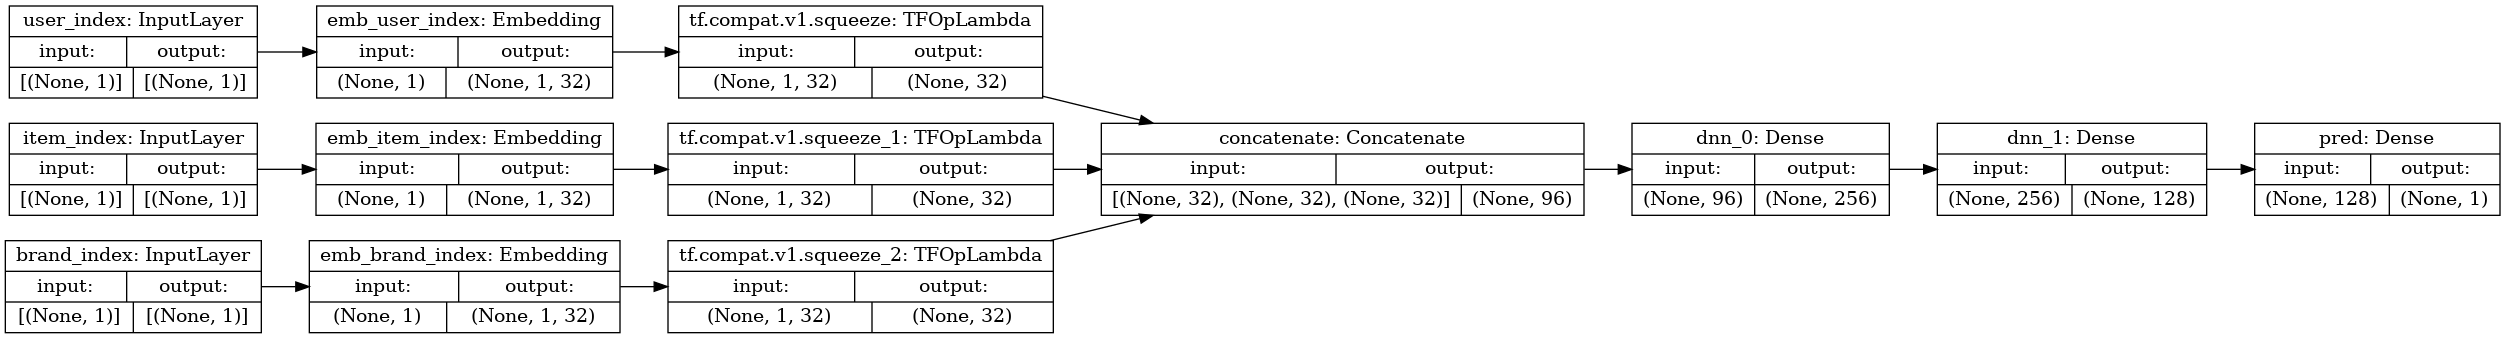

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

If the answer is yes to all of the above: great job, it's time for some training. If not, return to the cell that writes `deep.py` and double check where there were `FIXME`s.

In [20]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")]

model.compile(optimizer="adam", loss="mse", metrics=metrics)
model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

Epoch 1/2
1462/1462 [==============================] - 64s 43ms/step - loss: 2.5330 - rmse: 1.5106
{'val_loss': 2.459587, 'val_rmse': 1.212363}
Epoch 2/2
1462/1462 [==============================] - 60s 41ms/step - loss: 0.9883 - rmse: 0.9941
{'val_loss': 2.167026, 'val_rmse': 1.0277374}


Hmm, the results are about the same as before. Let's add more information and see if we can improve further.

## 3. Adding Numerical Features

Was the `# Ignore for now` column above obvious? Well, we won't ignore it any longer. We made our function so it was able to build in more layers. Let's take advantage of it.

Numerical features are another important feature type, which can significantly boost the performance of a deep recommender system.

Examples for numerical features could be:
* User's age, number of previous purchases, time past since last purchase, etc.
* Price, delivery time, items in cart, etc.

Neural networks converge better when the numerical input features are close to a normal distribution. Let's have a look on the raw input feature `price_filled`.

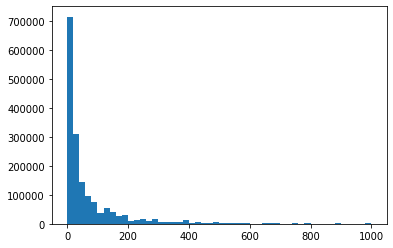

In [21]:
ratings = cudf.read_csv("data/task_2.csv")
_ = plt.hist(ratings["price_filled"].to_pandas(), bins=50)

Hmm, there's a [positive skew](https://en.wikipedia.org/wiki/Skewness#Introduction) on this dataset. We can use a trick to give it a nice normal bell shape. We'll take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) and make sure it's centered about the `mean` and scaled be the `standard deviation` so most of the data is between `-1` and `1`.

In [22]:
def log_norm(dataset, col):
    tmp = cp.log(dataset[col])
    mean = cp.mean(tmp)
    std = cp.std(tmp)
    dataset[col] = (tmp - mean) / std


log_norm(ratings, "price_filled")

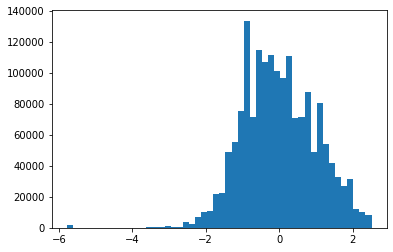

In [23]:
_ = plt.hist(ratings["price_filled"].to_pandas(), bins=50)

Similarly, the `salesRank_` columns (explained by Amazon [here](https://sellercentral.amazon.com/gp/help/external/G202059240?language=en_US)) are a ranking of how well an item sells within a category.

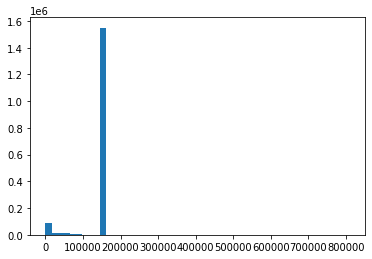

In [24]:
_ = plt.hist(ratings["salesRank_Electronics"].to_pandas(), bins=50)

In this case, we can apply a [Gaussian Rank Transformation](https://medium.com/rapids-ai/gauss-rank-transformation-is-100x-faster-with-rapids-and-cupy-7c947e3397da).

In [25]:
def apply_gauss_rank(dataset, col, epsilon = 1e-6):
    data = dataset[col].values
    r_gpu = data.argsort().argsort()
    r_gpu = (r_gpu/r_gpu.max()-0.5)*2 # scale to (-1,1)
    r_gpu = cp.clip(a=r_gpu,a_min=(-1+epsilon),a_max=(1-epsilon))
    r_gpu = erfinv(r_gpu)
    dataset[col] = r_gpu

We have a number of these `salesRank_` columns. Let's normalize all of them.

In [26]:
for col in [
    "salesRank_Electronics",
    "salesRank_Camera",
    "salesRank_Computers",
    "salesRank_CellPhones",
]:
    apply_gauss_rank(ratings, col)

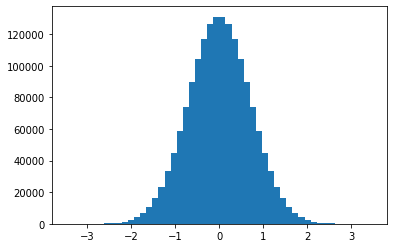

In [27]:
_ = plt.hist(ratings["salesRank_Electronics"].to_pandas(), bins=50)

A popular activation function for neurons is the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function which a computationally efficient way of introducing non-linearity into our neural network. If the sum of the inputs are negative, then the output is `0`, otherwise the output is the sum of the inputs.

<img src="images/relu.png" width="200">

If we do not normalize our data, we're more likely to have a large negative bias for our neuron, which means the output would always be `0`, which prevents the neuron from learning during backpropagation.

Now that our data is normalized, let's build our model! Here are our categorical inputs:

In [28]:
input_tensor

{'user_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'user_index')>,
 'item_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'item_index')>,
 'brand_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'brand_index')>}

Our goal is to add the numerical columns in this list:

In [29]:
continuous_columns = ["price_filled", "salesRank_Electronics"]

First, we create our new input layers.

In [30]:
tf.keras.backend.clear_session()
input_tensor_num = {
    col: tf.keras.layers.Input(name=col, shape=(1,), dtype="float32")
    for col in continuous_columns
}

Then, get our model using the `deep.get_model` tool we built earlier.

In [31]:
input_tensor_num

{'price_filled': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price_filled')>,
 'salesRank_Electronics': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'salesRank_Electronics')>}

In [32]:
concatenate_layers = list(input_tensor_num.values())
output_tensor = deep.get_model(
    embedding_inputs=input_tensor, concatenate_layers=concatenate_layers
)
input_tensor_num.update(input_tensor)
model = tf.keras.Model(input_tensor_num, output_tensor)

Let's visualize to check that everything is okay.

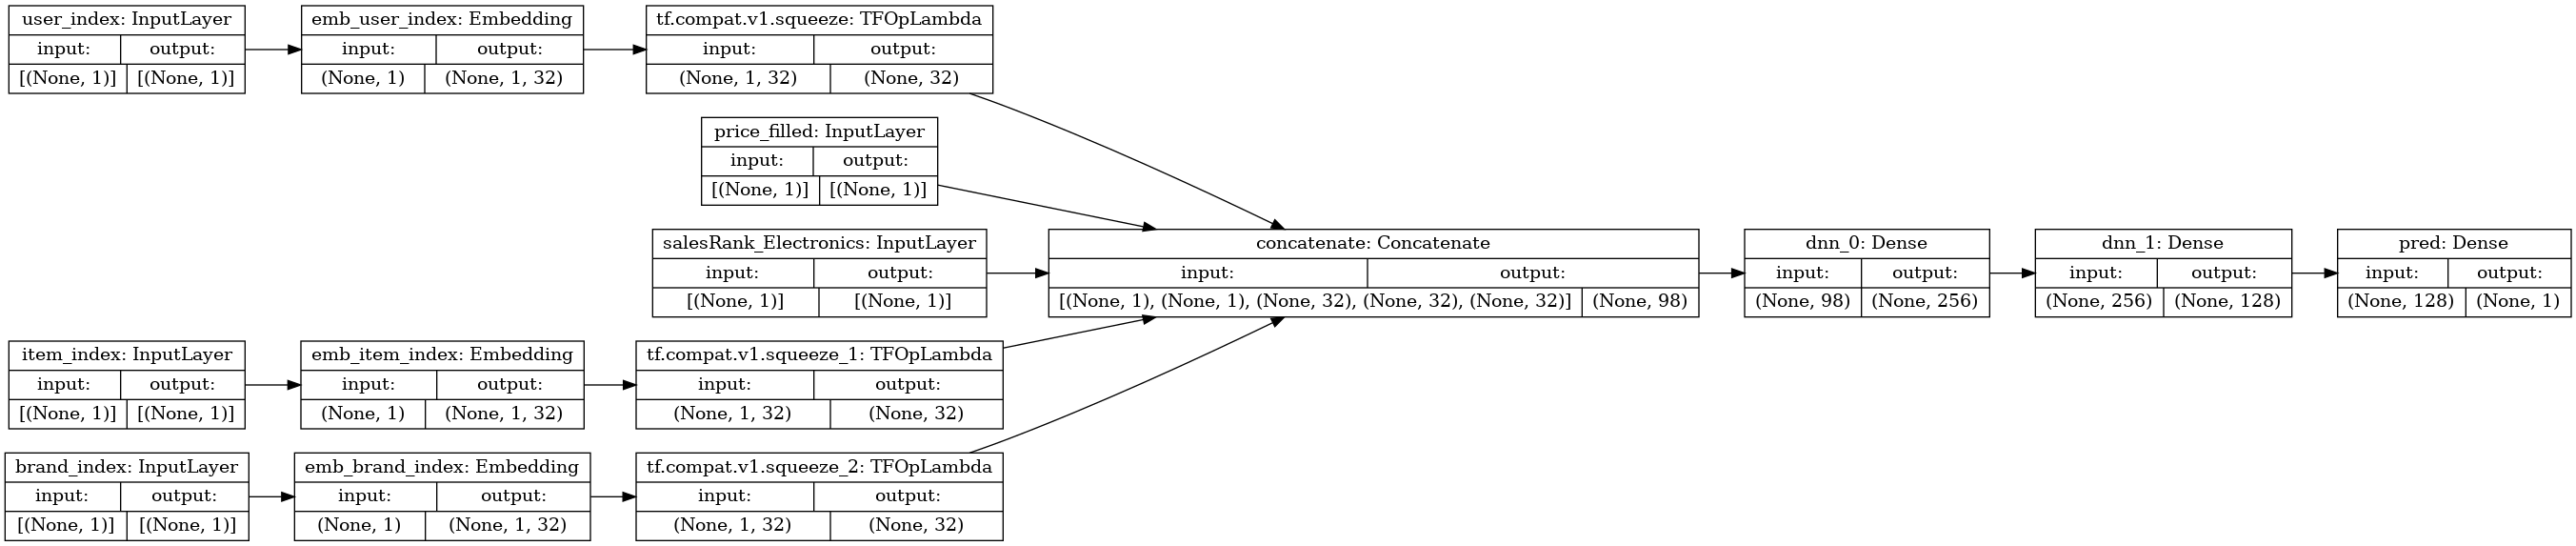

In [33]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

And finally, run the model!

In [34]:
train_ds, valid_ds = dataset.get_test_and_train(categorical_columns, continuous_columns, df=ratings)

In [35]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

model.compile(optimizer="adam", loss="mse", metrics=metrics)
model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

Epoch 1/2
1462/1462 [==============================] - 61s 41ms/step - loss: 2.2882 - rmse: 1.1152
{'val_loss': 2.4272366, 'val_rmse': 1.1150335}
Epoch 2/2
1462/1462 [==============================] - 65s 44ms/step - loss: 0.9946 - rmse: 0.9972
{'val_loss': 2.154123, 'val_rmse': 1.0286463}


Okay, a little better, but still more room to improve. Next, let's try multi-hot encoding.

## 4. Building a Multi-Hot Model

When we built our content-based filters, we found a list of all the categories available to our items and effectively created a Boolean column for each category. This is called multi-hot encoding, and let's do the same thing for our neural network. In particular, let's focus on the columns `category_0_2` and `category_1_2`.

We've already pulled in the indexes from our content-based filters lab into `category_0_2_index` and `category_0_1_index`.

In [36]:
multi_hot_names = ["category_0_2", "category_1_2"]
multi_hot_indexes = ["category_0_2_index", "category_1_2_index"]

These two columns share a lot of categories.  For example, let's take a look at some items categorized as `Routers`.

In [37]:
ratings.head()

,reviewerID,asin,overall,unixReviewTime,brand,category_0_0,category_0_1,category_0_2,category_0_3,category_1_0,...,user_index,item_index,brand_index,als_prediction,user_embed_0,user_embed_1,item_embed_0,item_embed_1,category_0_2_index,category_1_2_index
0,ARA6X7G3KBX39,B00005B4BW,1.0,1042243200,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,180332,781,0,3.105687,1.451223,-2.425463,0.715103,-1.195170,83,101
1,A231WM2Z2JL0U3,B00005B4BW,2.0,965433600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,55433,781,0,3.532970,1.650880,-2.759162,0.769520,-1.286120,83,101
2,A1O130H3XTF5WF,B00005B4BW,5.0,954460800,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,34202,781,0,3.962095,1.851401,-3.094298,0.820172,-1.370778,83,101
3,A2IIZ25SZSQGCC,B00005B4BW,4.0,1030233600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,77087,781,0,2.661104,1.243477,-2.078256,0.770355,-1.287510,83,101
4,A2BBDPGILE8EN4,B00005B4BW,1.0,1009497600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,67012,781,0,3.232237,1.510355,-2.524297,0.709057,-1.185062,83,101


In [38]:
check_category = "Routers"
check_indexes = (ratings["category_0_2"] == check_category) | (
    ratings["category_1_2"] == check_category
)
display_columns = multi_hot_names + multi_hot_indexes
ratings[check_indexes][display_columns].drop_duplicates()

,category_0_2,category_1_2,category_0_2_index,category_1_2_index
750597,Networking Products,Routers,102,126
27,Routers,NA,126,101


The process for making a multi-hot embedding is the same as for our one-hot embedding. First we define our inputs.

In [39]:
category_id_0 = Input(name="category_0_2_index", shape=(1,), dtype="int32")
category_id_1 = Input(name="category_1_2_index", shape=(1,), dtype="int32")

Then, we define the number of categories we're embedding and make our Embedding function.

In [40]:
embedding_size = 32
doc_max = max(ratings[multi_hot_indexes].to_pandas().max())
multihot_emb = Embedding(int(doc_max + 1), embedding_size)

Afterwards, we run our inputs through the Embedding.

In [41]:
emb_category_id_0 = multihot_emb(category_id_0)
emb_category_id_1 = multihot_emb(category_id_1)

There's a pretty cool trick we can do with these neural network Embeddings: we can take the average of them to further reduce the amount of data being fed into the network. This works well to reduce noise across a small number of columns, but doing it across too many columns would result in too much information loss.

Let's give it a try. First, we'll stack our Embeddings.

In [42]:
emb_stack = tf.keras.backend.stack([emb_category_id_0, emb_category_id_1], axis=2)

And then we take the average across the `2`nd axis, the `0`th axis being the batch size and the `1`st axis being the embedding columns for each row in the batch.

In [43]:
emb_avg = tf.squeeze(tf.keras.backend.mean(emb_stack, axis=2), axis=1)

Alright, we have all the pieces. Let's put them together into one big model!
Here are our input tensors from last time.

In [44]:
input_tensor_num

{'price_filled': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price_filled')>,
 'salesRank_Electronics': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'salesRank_Electronics')>,
 'user_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'user_index')>,
 'item_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'item_index')>,
 'brand_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'brand_index')>}

As well as our layers that we concatenated.

In [45]:
concatenate_layers

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price_filled')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'salesRank_Electronics')>]

Let's define our multi-hot inputs.

In [46]:
input_tensor_hot = {
    "category_0_2_index": category_id_0,
    "category_1_2_index": category_id_1,
}
input_tensor_hot.update(input_tensor_num)
input_tensor_hot

{'category_0_2_index': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'category_0_2_index')>,
 'category_1_2_index': <KerasTensor: shape=(None, 1) dtype=int32 (created by layer 'category_1_2_index')>,
 'price_filled': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'price_filled')>,
 'salesRank_Electronics': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'salesRank_Electronics')>,
 'user_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'user_index')>,
 'item_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'item_index')>,
 'brand_index': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'brand_index')>}

And, update the layers we concatenate.

In [47]:
concatenate_layers_hot = concatenate_layers + [emb_avg]

Let's compile our model and do one last visual check to make sure everything is in order.

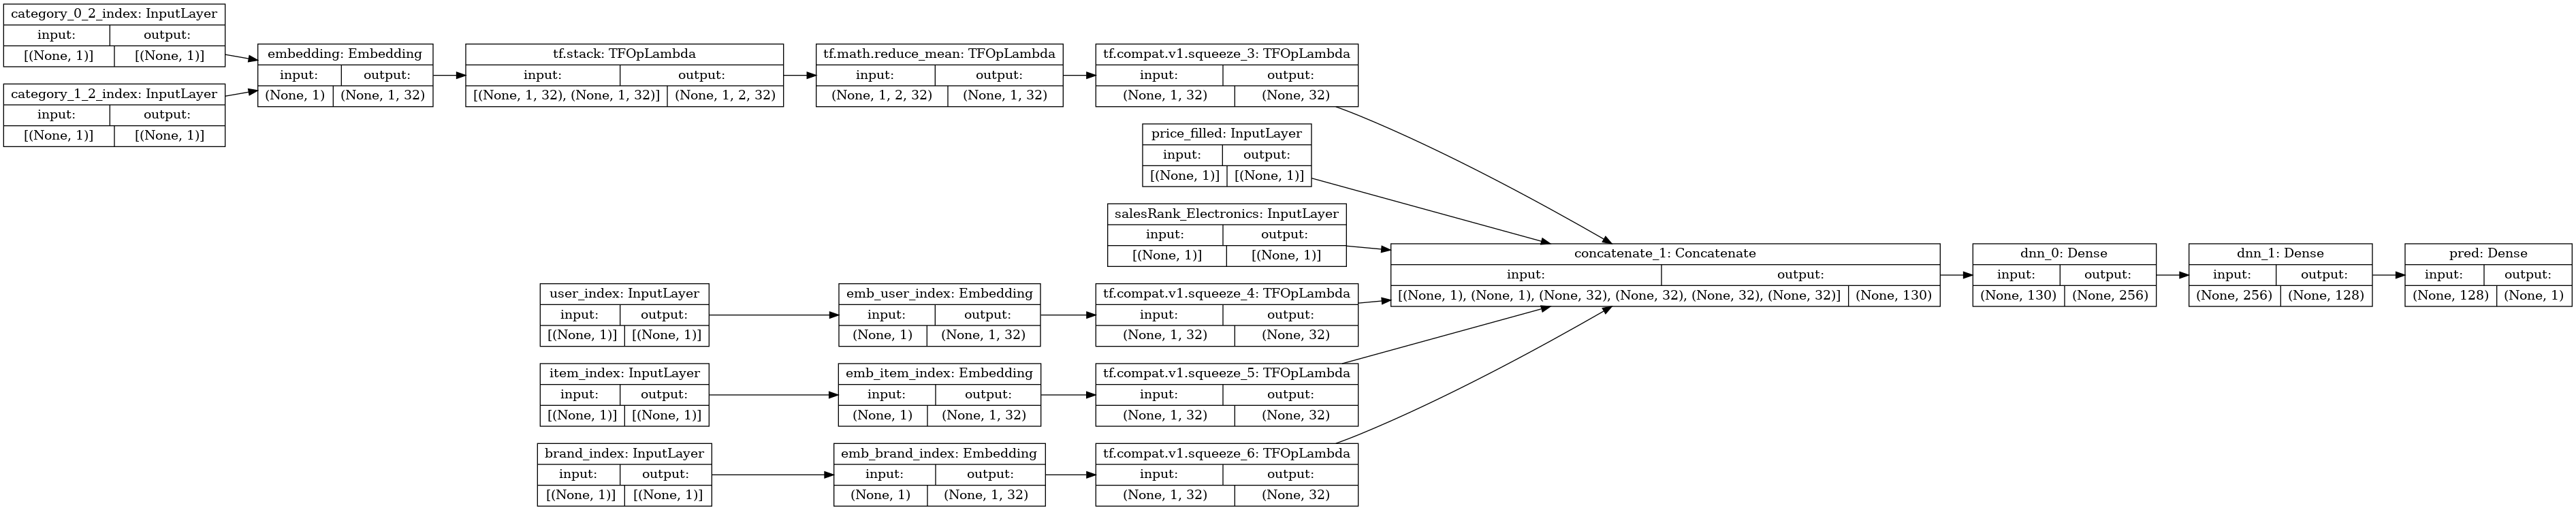

In [48]:
output_tensor = deep.get_model(
    embedding_inputs=input_tensor, concatenate_layers=concatenate_layers_hot
)
model = tf.keras.Model(input_tensor_hot, output_tensor)
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Finally, let's load the new columns we'll need into our dataset.

In [49]:
train_ds, valid_ds = dataset.get_test_and_train(categorical_columns+multi_hot_indexes, 
                                                continuous_columns, df=ratings)

Can we do it? Can we get below an RMSE of `1.14`?

In [53]:
ratings.head()

,reviewerID,asin,overall,unixReviewTime,brand,category_0_0,category_0_1,category_0_2,category_0_3,category_1_0,...,user_index,item_index,brand_index,als_prediction,user_embed_0,user_embed_1,item_embed_0,item_embed_1,category_0_2_index,category_1_2_index
0,ARA6X7G3KBX39,B00005B4BW,1.0,1042243200,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,180332,781,0,3.105687,1.451223,-2.425463,0.715103,-1.195170,83,101
1,A231WM2Z2JL0U3,B00005B4BW,2.0,965433600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,55433,781,0,3.532970,1.650880,-2.759162,0.769520,-1.286120,83,101
2,A1O130H3XTF5WF,B00005B4BW,5.0,954460800,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,34202,781,0,3.962095,1.851401,-3.094298,0.820172,-1.370778,83,101
3,A2IIZ25SZSQGCC,B00005B4BW,4.0,1030233600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,77087,781,0,2.661104,1.243477,-2.078256,0.770355,-1.287510,83,101
4,A2BBDPGILE8EN4,B00005B4BW,1.0,1009497600,<NA>,Electronics,Camera & Photo,Lighting & Studio,Photo Studio,NA,...,67012,781,0,3.232237,1.510355,-2.524297,0.709057,-1.185062,83,101


In [ ]:
from nvtabular.loader.tensorflow import KerasSequenceValidater

model.compile(optimizer="adam", loss="mse", metrics=metrics)
model.fit(train_ds, callbacks=[KerasSequenceValidater(valid_ds)], epochs=2)

## 5. Wrap Up

So close and yet so far! We're not out of tricks yet. Let's save the changes to our dataset and shut down the kernel before moving on to the next notebook.

In [52]:
# Lower chunksize below if running into memory issues 
ratings.to_pandas().to_csv("data/wide_and_deep.csv", chunksize=2000, index=False)

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="./images/DLI_Header.png"></a></div>